In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

height = 64
width = 64
image0 = np.zeros((height, width), dtype=np.uint8) 

def computehoughTransformCoord(x1, y1, x2, y2):

    if x1 == x2:
        return(np.pi/2, abs(y1-y2), abs(x1))

    k =  (y1 - y2) / (x1 - x2)
    theta = np.arctan(k)

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = abs(C / length)
    
    return np.degrees(theta), length, rho

def simulateSigma(image0, noise_std, low, high, thetaT = 45, iterNum = 2000, draw = False):

    print(thetaT)
    height, width = image0.shape

    rhoT = 32 * np.sqrt(2) * np.sin(np.radians(thetaT - 45))
    rhoT = abs(rhoT)

    # for i in range(0, height):
    #     image0[i, 0: height-i] = low
    #     image0[i, height-i : height] = high

    # image0[0:bound, :] = high
    # image0[bound:, :] = low

    f = lambda x, y: (x - width/2) * slope - (y - height/2) 

    slope = math.tan(math.radians(thetaT))  # 60度的斜率
    for x in range(width):
        for y in range(height):
            if f(x, y) > 0:
                image0[y, x] = low
            else:
                image0[y, x] = high

    lsd = cv2.createLineSegmentDetector(0)
    thetaList = []
    rhoList = []

    for iter in range(0, 1000):
        image = image0 + np.round(np.random.normal(0, noise_std, image0.shape)).astype(int)
        image = np.uint8(image)

        if draw == True:
            cv2.imwrite("blur_image.png", image)

        lines, width, prec, nfa = lsd.detect(image)

        drawn_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if lines is None:
            print("================empty lines==============")
        else:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                theta, length, rho = computehoughTransformCoord(x1, y1, x2, y2)

                if abs( rho - rhoT ) > 2 or abs(theta - thetaT) > 5:
                    # s=1
                    continue

                thetaList.append(theta)
                rhoList.append(rho)

                if draw == True:
                    x1, y1, x2, y2 = map(int, line[0])
                    drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)

                print(f"theta : {theta}, rho : {rho}")
            if draw == True:
                cv2.imwrite(f"Draw/drawn_img{iter}.png", drawn_img)

    thetaList = np.asarray(thetaList)
    rhoList = np.asarray(rhoList)
    thetaSigma = np.std(thetaList)
    rhoSigma = np.std(rhoList)
    # print(np.mean(rhoList))
    # print(thetaSigma, rhoSigma)
    return thetaList, rhoList

40
theta : 40.18241882324219, rho : 3.8379229465886873
theta : 40.14668273925781, rho : 3.902385446627689
theta : 40.02523422241211, rho : 3.8573756598669657
theta : 40.025665283203125, rho : 3.950686313744395
theta : 41.49229431152344, rho : 3.636044949707683
theta : 40.054473876953125, rho : 3.8921626640925204
theta : 40.02932357788086, rho : 3.9268155325601724
theta : 40.2176513671875, rho : 3.6935786612752763
theta : 39.94964599609375, rho : 4.054641140697934
theta : 40.12603759765625, rho : 3.852561839429516
theta : 39.705474853515625, rho : 4.1611515678620625
theta : 40.089900970458984, rho : 3.8365967856448777
theta : 40.14103317260742, rho : 3.7722037028452187
theta : 39.8856315612793, rho : 4.042221407023926
theta : 40.084041595458984, rho : 3.91566655653054
theta : 40.13890075683594, rho : 3.8271701871003208
theta : 39.96783447265625, rho : 3.9386653402652256
theta : 40.181976318359375, rho : 3.744614120042002
theta : 40.03564453125, rho : 3.9027176999808417
theta : 40.055931

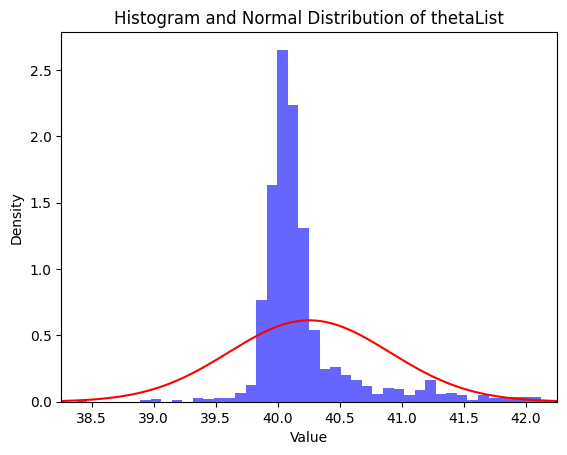

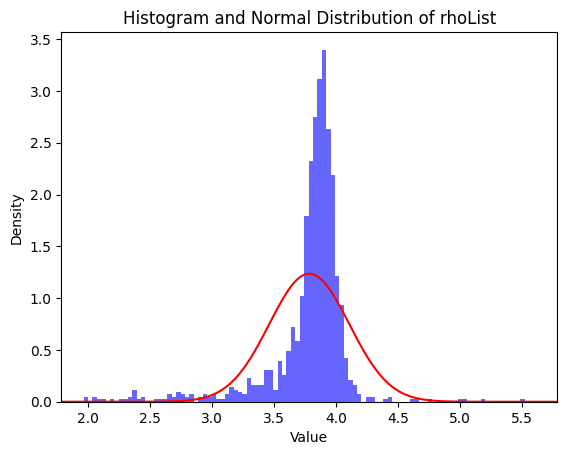

In [40]:
thetaList, rhoList = simulateSigma(image0, 20, 70, 180, thetaT=40, iterNum=10000, draw=True)

with open('output.txt', 'w') as file:
    for item in thetaList:
        file.write(str(item) + '\n')

# thetaList = np.sin(thetaList)

# 计算thetaList的均值和方差
mean = np.mean(thetaList)
std_dev = np.std(thetaList)

mean_rho = np.mean(rhoList)
std_rho = np.std(rhoList)

# 生成正态分布曲线的x值
x = np.linspace(mean - 2, mean + 2, 1000)

# 生成正态分布曲线的y值
y = norm.pdf(x, mean, std_dev)

# 绘制直方图
plt.figure()
plt.hist(thetaList, bins=100, density=True, alpha=0.6, color='b')

# 绘制正态分布曲线
plt.plot(x, y, 'r')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram and Normal Distribution of thetaList')
plt.xlim(mean - 2, mean + 2)
plt.show()

# 生成正态分布曲线的x值
x = np.linspace(mean_rho - 2, mean_rho + 2, 1000)

# 生成正态分布曲线的y值
y = norm.pdf(x, mean_rho, std_rho)

# 绘制直方图
plt.figure()
plt.hist(rhoList, bins=100, density=True, alpha=0.6, color='b')

# 绘制正态分布曲线
plt.plot(x, y, 'r')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram and Normal Distribution of rhoList')
plt.xlim(mean_rho - 2, mean_rho + 2)
plt.show()